# 1.Reading and Understanding the Data 

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from keras.models import Model
from keras.layers import Input, Dense
from keras.callbacks import TensorBoard
from keras import regularizers

In [29]:
data = pd.read_csv("../creditcard.csv")

In [30]:
print(data.shape)

(284807, 31)


In [31]:
print(data.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [32]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

There are not any null values in the dataset.

# 2. Exploratory Data Analysis

In [33]:
fraud = data[data.Class==1]
no_fraud = data[data.Class==0]
print("The shape of no_fraud data:", no_fraud.shape)
print("The shape of fraud data:", fraud.shape)

The shape of no_fraud data: (284315, 31)
The shape of fraud data: (492, 31)


There are 492 fraud cases and 284.315 nonfraudulent cases in the dataset. The percentage of no fraud cases is quite higher than fraud cases.

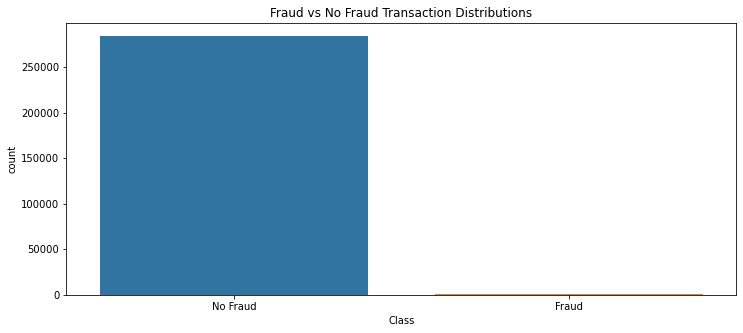

In [34]:
plt.figure(figsize=(12,5))
sns.countplot(x="Class", data=data)
plt.title("Fraud vs No Fraud Transaction Distributions")
plt.xticks(range(2), ["No Fraud", "Fraud"])
plt.show() 

In [35]:
print("Non-Fraudulent Transaction")
print(no_fraud.Amount.describe())
print("\nFraudulent Transaction")
print(fraud.Amount.describe())

Non-Fraudulent Transaction
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Fraudulent Transaction
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


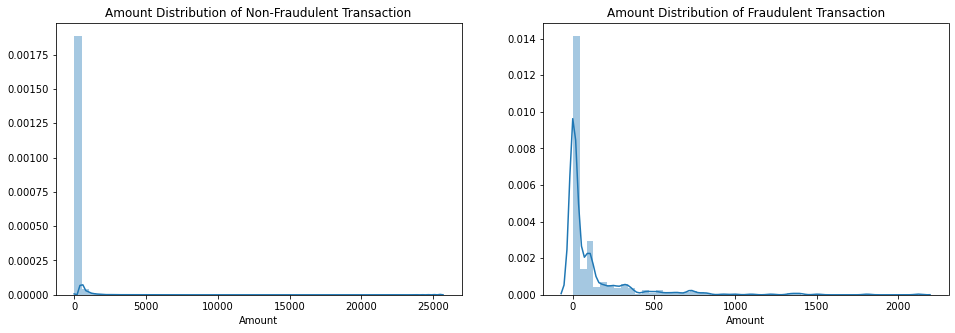

In [36]:
plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
sns.distplot(no_fraud['Amount'])
plt.title("Amount Distribution of Non-Fraudulent Transaction")

plt.subplot(1,2,2)
sns.distplot(fraud['Amount'])
plt.title("Amount Distribution of Fraudulent Transaction")

plt.show()

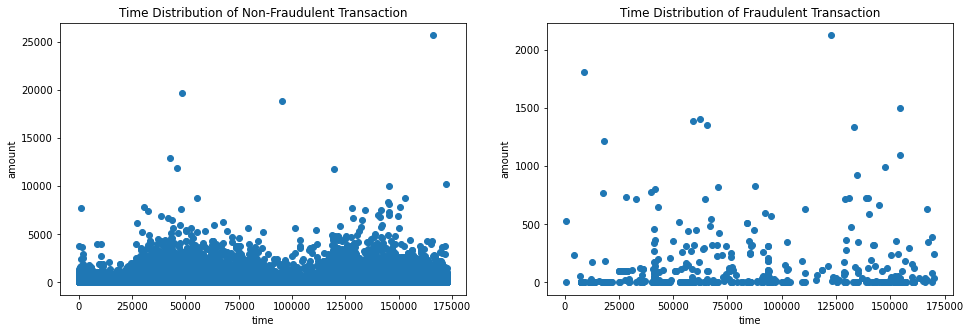

In [37]:
plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
plt.scatter(no_fraud.Time, no_fraud.Amount)
plt.title("Time Distribution of Non-Fraudulent Transaction")
plt.xlabel("time")
plt.ylabel("amount")

plt.subplot(1,2,2)
plt.scatter(fraud.Time, fraud.Amount)
plt.title("Time Distribution of Fraudulent Transaction")
plt.xlabel("time")
plt.ylabel("amount")

plt.show()

Graph shows that the time is not related with the fraud activities, that's why I will drop "time" from the dataset.

# 3. Data Preparation

In [38]:
data = data.drop(['Time'], axis=1)

### Scaling the Data

We need to scale "amount" column for optimal performance. Other columns of the dataset are already scaled.

In [39]:
from sklearn.preprocessing import StandardScaler

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

### Splitting the Data

We want to detect anomalies in our dataset, that's why we need to train the model with just nonfrudulent data. After training, the model will be able to separate the nonfraudulent cases. It means reconstruction loss will be very low for nonfraudulent cases. If we pass fraud cases, we will get a high reconstruction loss value because the network fails to reconstruct the input that is considered an anomaly.

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)

X_train = X_train[X_train.Class==0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [41]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (227451, 29)
Shape of X_test: (56962, 29)


# 4. Autoencoder Model

Input layer has 29 nodes. Hidden layers have 14, 7, 14 nodes respectively. Output layer has 29 nodes which is the same number of nodes with the input layer.

In [42]:
input_size = X_train.shape[1]
encoding_size = 14

In [43]:
input_layer = Input(shape=(input_size, ))

encoder_1 = Dense(encoding_size, activation="relu", activity_regularizer=regularizers.l1(1e-5))(input_layer)
encoder_2 = Dense(int(encoding_size / 2), activation="relu")(encoder_1)
decoder_1 = Dense(encoding_size, activation='relu')(encoder_2)
output_layer = Dense(input_size, activation='relu')(decoder_1)

autoencoder = Model(inputs=input_layer, outputs=output_layer)

I will use TensorBoard which is a visualization tool provided with TensorFlow so that we will be able to visualize training graph.

In [44]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir='./logs', write_images=True)

history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=16, shuffle=True, validation_data=(X_test, X_test),
                  callbacks=[tensorboard]).history

Train on 227451 samples, validate on 56962 samples
Epoch 1/50
227451/227451 [==============================] - 18s 78us/step - loss: 0.7380 - accuracy: 0.6513 - val_loss: 0.7369 - val_accuracy: 0.7017
Epoch 2/50
227451/227451 [==============================] - 17s 74us/step - loss: 0.6898 - accuracy: 0.7214 - val_loss: 0.7236 - val_accuracy: 0.7315
Epoch 3/50
227451/227451 [==============================] - 17s 73us/step - loss: 0.6824 - accuracy: 0.7356 - val_loss: 0.7198 - val_accuracy: 0.7423
Epoch 4/50
227451/227451 [==============================] - 17s 73us/step - loss: 0.6790 - accuracy: 0.7410 - val_loss: 0.7134 - val_accuracy: 0.7519
Epoch 5/50
227451/227451 [==============================] - 17s 74us/step - loss: 0.6743 - accuracy: 0.7454 - val_loss: 0.7104 - val_accuracy: 0.7481
Epoch 6/50
227451/227451 [==============================] - 17s 76us/step - loss: 0.6723 - accuracy: 0.7471 - val_loss: 0.7085 - val_accuracy: 0.7484
Epoch 7/50
227451/227451 [=======================

# 5. Evaluation

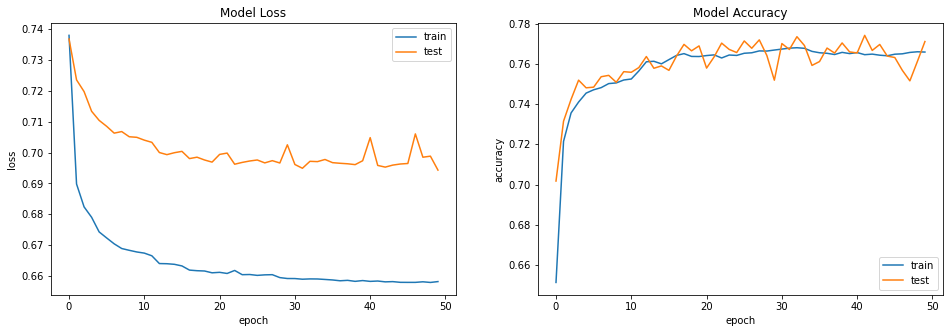

In [45]:
plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

plt.subplot(1,2,2)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.show()

In [46]:
prediction = autoencoder.predict(X_test)

In [47]:
mse = np.mean(np.power(X_test - prediction, 2), axis=1)
error = pd.DataFrame({'reconstruction_error': mse, 'actual_class': y_test})

In [48]:
without_fraud = error[error.actual_class==0]
with_fraud = error[error.actual_class==1]

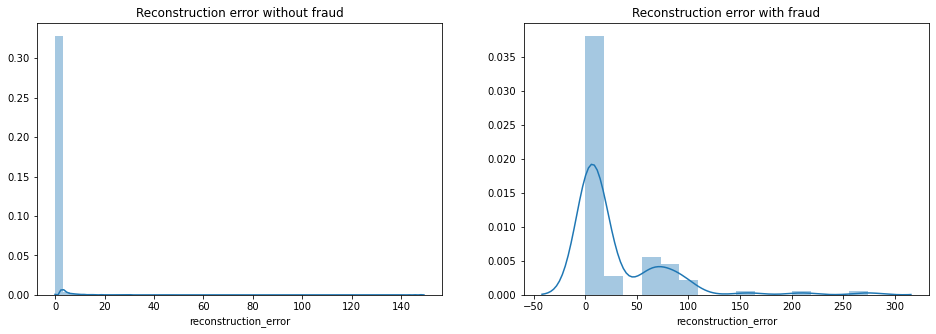

In [49]:
plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
sns.distplot(without_fraud["reconstruction_error"])
plt.title("Reconstruction error without fraud")

plt.subplot(1,2,2)
sns.distplot(with_fraud["reconstruction_error"])
plt.title("Reconstruction error with fraud")

plt.show()


Reconstruction error is quite high for the fraudulent cases since the model see these data points for the first time. Since we trained the model with just nonfraudulent cases, reconstruction error is quite low for nonfraudulent cases.

In [50]:
from sklearn.metrics import confusion_matrix
y_pred = [1 if e > 3 else 0 for e in error.reconstruction_error.values]
print('Confusion Matrix\n' + str(confusion_matrix(y_test, y_pred)))

Confusion Matrix
[[55639  1225]
 [   21    77]]


The model is trained with nonfraudulent transactions, and learned how to separate different examples (fraudulent cases). On the other hand, the number of nonfraudulent cases that is predicted as fraud is quite high with 1225. This may be a problem. The model also could not catch 21 fraudulent transactions, and evaluated as nonfraudulent transaction, but the number is not high.